In [ ]:
!pip install seaborn

In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import HTML
from base64 import b64encode


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
NonViolnceVideos_Dir = "/kaggle/input/filtered-violence-dataset/Filtered_Dataset/Violence"
ViolnceVideos_Dir = "/kaggle/input/filtered-violence-dataset/Filtered_Dataset/NonViolence"

In [6]:
NonViolnceVideos_Dir = "/kaggle/input/updated-violence-dataset/Updated_Dataset/Violence"
ViolnceVideos_Dir = "/kaggle/input/updated-violence-dataset/Updated_Dataset/NonViolence"

In [4]:
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

In [8]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
print(Random_NonViolence_Video)
Random_Violence_Video = random.choice(Violence_files_names_list)

V_391.mp4


In [9]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [10]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [14]:
IMAGE_HEIGHT,IMAGE_WIDTH=120,120
SEQUENCE_LENGTH = 16

In [6]:
DATASET_DIR = "/kaggle/input/filtered-violence-dataset/Filtered_Dataset/"

In [10]:
DATASET_DIR = "/kaggle/input/updated-violence-dataset/Updated_Dataset/"

In [16]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [29]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [11]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

creating dataset for 500 videos of each class****

In [ ]:
import os
import numpy as np

def create_dataset(max_videos_per_class=500):
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        count = 0
        for file_name in files_list:
            if count >= max_videos_per_class:
                break  

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                count += 1  

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [11]:
features, labels, video_files_paths = create_dataset()
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

Extracting Data of Class: NonViolence


[h264 @ 0x5a3186363280] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a3186363280] error while decoding MB 98 31
[h264 @ 0x5a3186363280] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a3186363280] error while decoding MB 98 31
[h264 @ 0x5a3186363280] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a3186363280] error while decoding MB 98 31
[h264 @ 0x5a3186363280] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a3186363280] error while decoding MB 98 31


Extracting Data of Class: Violence


In [3]:
features = np.load("features.npy", allow_pickle=True)
labels = np.load("labels.npy", allow_pickle=True)
video_files_paths = np.load("video_files_paths.npy", allow_pickle=True)

In [4]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [5]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(899, 16, 120, 120, 3) (899, 2)
(100, 16, 120, 120, 3) (100, 2)


In [6]:
mobilenet = MobileNetV2(include_top=False, weights="imagenet")
mobilenet.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
for layer in mobilenet.layers[:-20]:
    layer.trainable = False

In [ ]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_forward = LSTM(units=32)
    lstm_backward = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_forward, backward_layer=lstm_backward))

    model.add(Dropout(0.35))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    

    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 3, 3, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 3, 3, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 11520)         0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                2957568   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

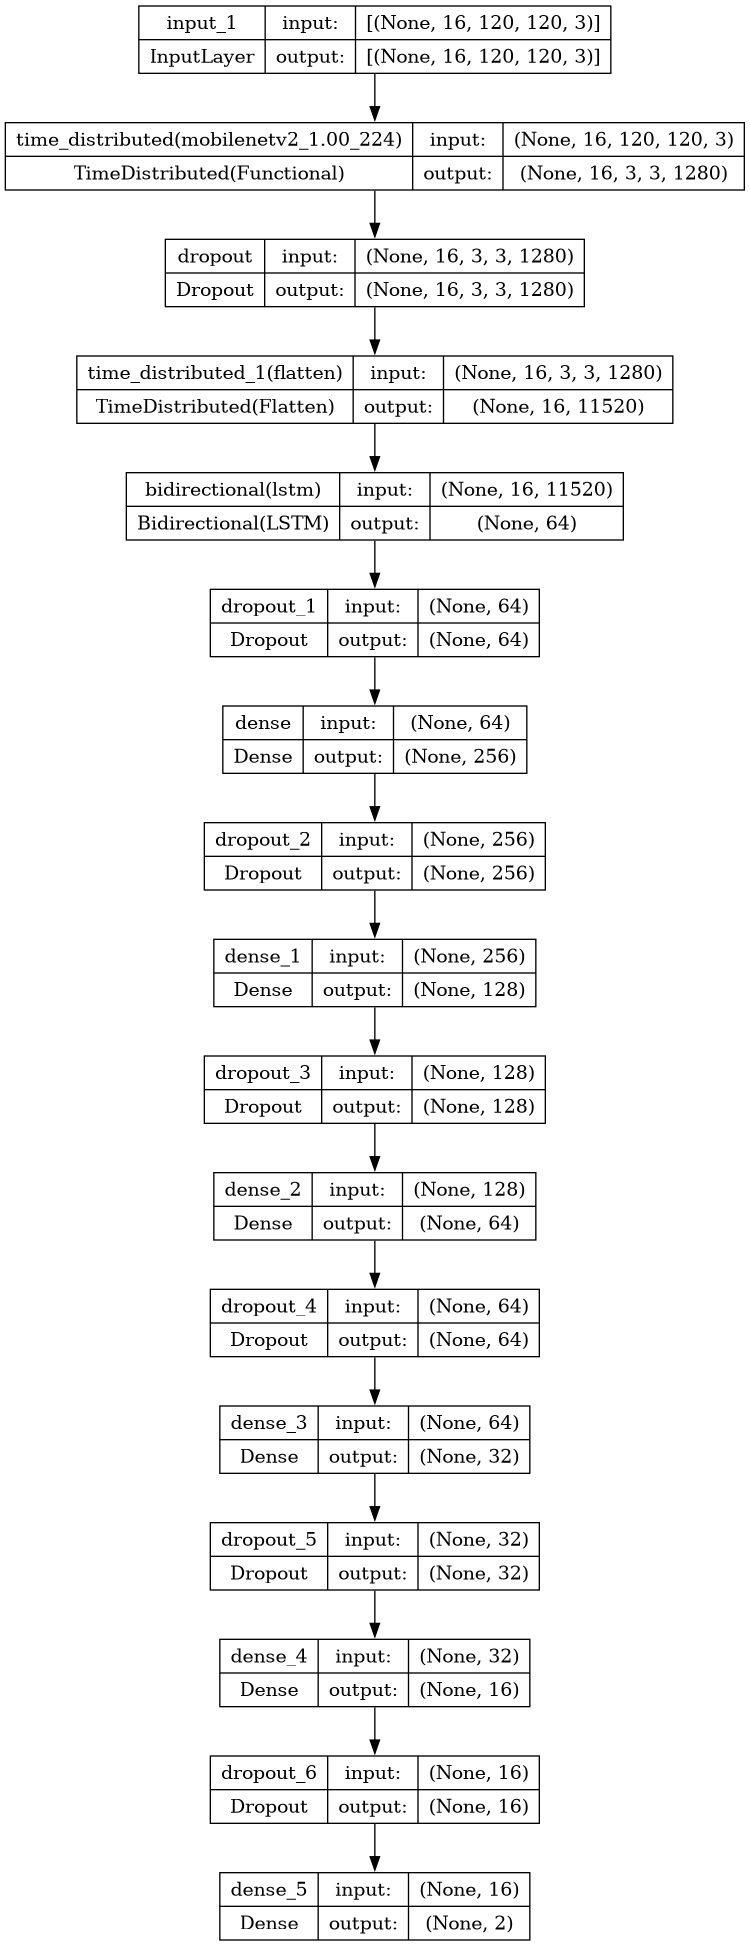

In [21]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=10, min_lr=0.00005, verbose=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_weights.h5',  # Save the weights to this file
    monitor='val_accuracy', 
    save_best_only=True, 
    save_weights_only=True, 
    verbose=1
)

In [23]:
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])
MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[early_stopping_callback, reduce_lr])


Epoch 1/50
90/90 [==============================] - 24s 136ms/step - loss: 0.7215 - accuracy: 0.4826 - val_loss: 0.6919 - val_accuracy: 0.5056 - lr: 0.0100
Epoch 2/50
90/90 [==============================] - 8s 85ms/step - loss: 0.7002 - accuracy: 0.5021 - val_loss: 0.6910 - val_accuracy: 0.4778 - lr: 0.0100
Epoch 3/50
90/90 [==============================] - 8s 85ms/step - loss: 0.6852 - accuracy: 0.5438 - val_loss: 0.6895 - val_accuracy: 0.5056 - lr: 0.0100
Epoch 4/50
90/90 [==============================] - 8s 85ms/step - loss: 0.6823 - accuracy: 0.5549 - val_loss: 0.6863 - val_accuracy: 0.4833 - lr: 0.0100
Epoch 5/50
90/90 [==============================] - 8s 85ms/step - loss: 0.6689 - accuracy: 0.5911 - val_loss: 0.6602 - val_accuracy: 0.7222 - lr: 0.0100
Epoch 6/50
90/90 [==============================] - 8s 85ms/step - loss: 0.6521 - accuracy: 0.6287 - val_loss: 0.6184 - val_accuracy: 0.8056 - lr: 0.0100
Epoch 7/50
90/90 [==============================] - 8s 85ms/step - loss: 0

In [24]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 96ms/step - loss: 0.1492 - accuracy: 0.9500


In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

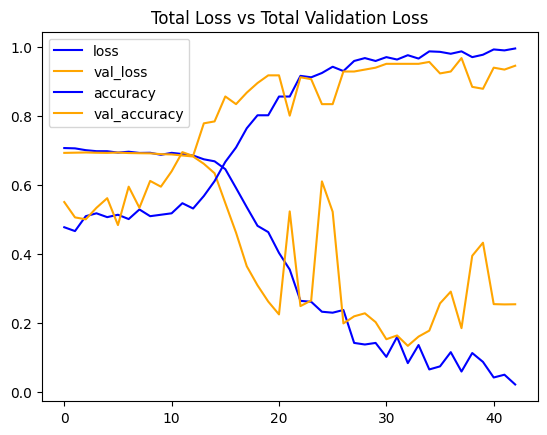

In [24]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [25]:
labels_predict = MoBiLSTM_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

4/4 [==============================] - 3s 88ms/step


In [26]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.95


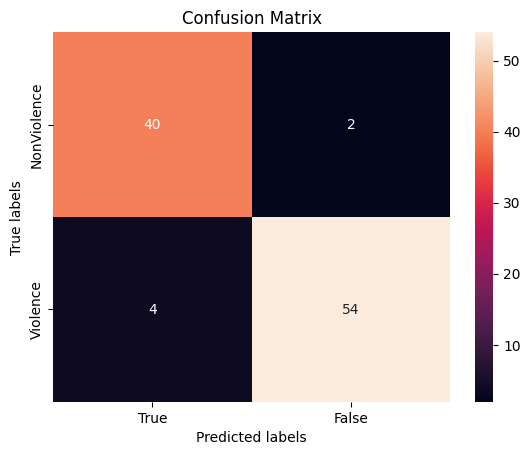

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

# Save the plot as a PNG file
plt.savefig('/kaggle/working/confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot (optional)
plt.show()

In [29]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal, labels_predict)
print('Classification Report is : \n', ClassificationReport)


Classification Report is : 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        42
           1       0.96      0.93      0.95        58

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [32]:
MoBiLSTM_model.save_weights('model_weights474.h5')

In [17]:
import tensorflow as tf

# Clear the current TensorFlow session
tf.keras.backend.clear_session()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, TimeDistributed, Bidirectional, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

strategy = tf.distribute.TPUStrategy(tpu)

def create_vgg19_model():
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    vgg19.trainable = True

    for layer in vgg19.layers[:-10]:  
        layer.trainable = False

    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(vgg19)) 
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))  
    
    lstm_forward = LSTM(units=32)
    lstm_backward = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_forward, backward_layer=lstm_backward))

    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

with strategy.scope():
    VGG19_LSTM_model = create_vgg19_model()

    plot_model(VGG19_LSTM_model, to_file='VGG19_LSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

    early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=10, min_lr=0.00005, verbose=1)

    VGG19_LSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


In [ ]:
VGG19_LSTM_model_history = VGG19_LSTM_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=8,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping_callback, reduce_lr]
)

In [22]:
model_evaluation_history = VGG19_LSTM_model.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 670ms/step - loss: 0.2510 - accuracy: 0.9100


In [23]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.savefig(f'/kaggle/working/graph')
    plt.legend()

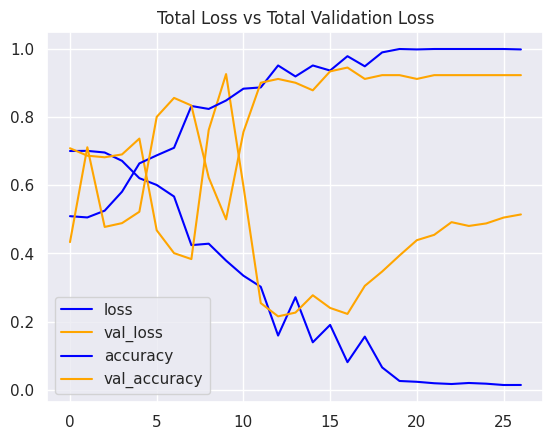

In [24]:
plot_metric(VGG19_LSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric(VGG19_LSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [66]:
plt.savefig(f'/kaggle/working/graph3')

<Figure size 640x480 with 0 Axes>

In [67]:
labels_predict = VGG19_LSTM_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

2/2 [==============================] - 2s 9ms/step


In [68]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8


In [28]:
VGG19_LSTM_model.save_weights('weights231.h5')